In [45]:
import numpy as np
import sqlite3
import plotly.express as px
import pandas as pd
import sqlite3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import statsmodels
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from useful_functions import *
from pdf2image import convert_from_path

In [46]:
tables_to_join = ["tSoilNutrients", "tPlantDNA", "tSample"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
full_df.shape

(160, 29)

In [47]:
full_df = full_df.T.drop_duplicates().T

In [48]:
full_df.head()

,sample_id,OM,ENR,CEC,pH,BpH,Phosphorus,Potassium,Calcium,Magnesium,...,V1,V2,species,PC1,PC2,PC3,PC4,PC5,site_id,collect_date
0,RRL1,19.4,150.0,9.5,5.9,6.77,10.0,180.0,1200.0,153.0,...,0.753244,0.246756,exaltata,0.194769,0.048276,-0.02388,-0.017138,-0.039842,RRL,6/25/2021
1,RRL9,17.6,150.0,4.8,5.4,6.79,11.0,107.0,471.0,89.0,...,0.581366,0.418634,exaltata,0.097719,0.094733,-0.00656,0.012822,-0.022248,RRL,6/25/2021
2,RRL17,14.7,150.0,6.7,6.0,6.83,9.0,172.0,824.0,133.0,...,0.591513,0.408487,exaltata,0.099527,0.091996,0.004098,-0.021347,0.00719,RRL,6/25/2021
3,FRW3,11.2,150.0,15.0,6.4,6.8,25.0,133.0,2437.0,127.0,...,0.048066,0.951934,syriaca,-0.139465,-0.064022,-0.009963,-0.047536,0.024757,FRW,6/25/2021
4,FRW12,11.9,150.0,12.8,6.6,6.85,25.0,137.0,2098.0,130.0,...,0.003946,0.996054,syriaca,-0.155135,0.055455,0.009907,-0.043334,-0.009337,FRW,6/25/2021


In [49]:
df = full_df.copy()

In [50]:
nutrients = df.columns.drop(['sample_id','site_id','collect_date','V1', 'V2', 'species', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
print(nutrients)

Index(['OM', 'ENR', 'CEC', 'pH', 'BpH', 'Phosphorus', 'Potassium', 'Calcium',
       'Magnesium', 'Sulfur', 'Sodium', 'Zinc', 'Manganese', 'Iron', 'Copper',
       'Boron'],
      dtype='object')


In [51]:
df = df[df["species"].isin(['syriaca','exaltata'])]
df.shape

(151, 27)

In [52]:
site_list = df['site_id']

df['BGR'] = site_list

df['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
df = df[df["BGR"].isin([0,1,2,3])]

df['BGR'] = df['BGR'].replace([0], 'Wintergreen')
df['BGR'] = df['BGR'].replace([1], 'Cole Mountain')
df['BGR'] = df['BGR'].replace([2], 'Blacksburg')
df['BGR'] = df['BGR'].replace([3], 'HR')

### Combined Soil Nutrients PCA Figure

In [53]:
df[nutrients] = StandardScaler().fit_transform(df[nutrients])  

In [54]:
site_list = ['RRL', 'FRW', 'MMP', 'PNR', 'CMB', 'SLG', 'RF', 'LFS', 'PTW', 'LM', 'MKP', 'RGT']

# Predefined set of colors
unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'pink', 'brown', 'gray', 'olive', 'lime', 'teal']

# Create a dictionary with list elements as keys and corresponding colors as values
site_color_dict = dict(zip(site_list, unique_colors))

print(site_color_dict)

{'RRL': 'red', 'FRW': 'green', 'MMP': 'blue', 'PNR': 'orange', 'CMB': 'purple', 'SLG': 'cyan', 'RF': 'pink', 'LFS': 'brown', 'PTW': 'gray', 'LM': 'olive', 'MKP': 'lime', 'RGT': 'teal'}


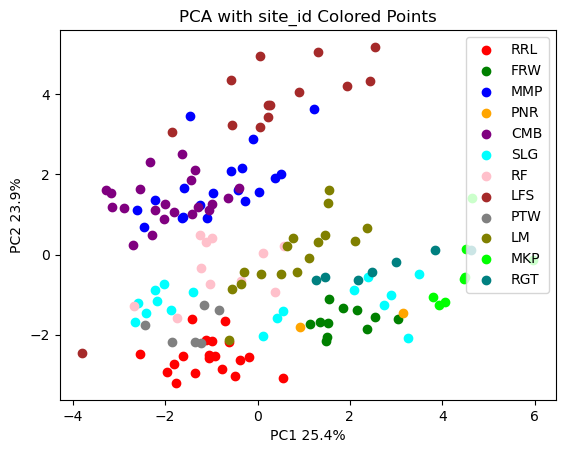

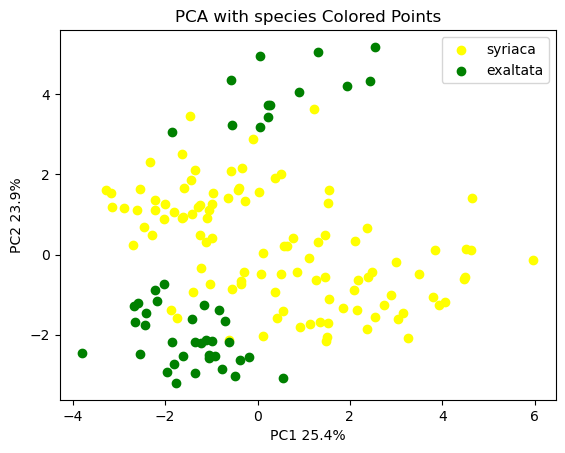

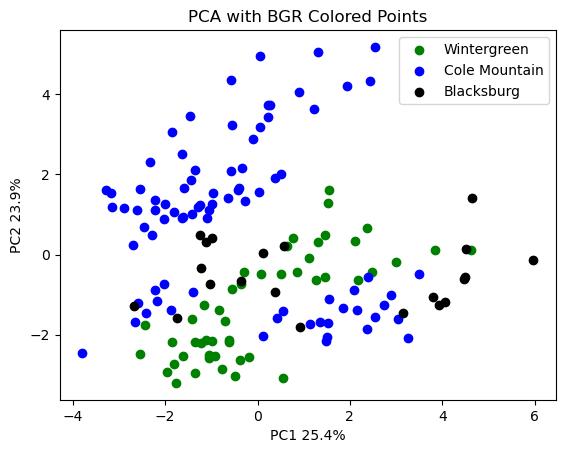

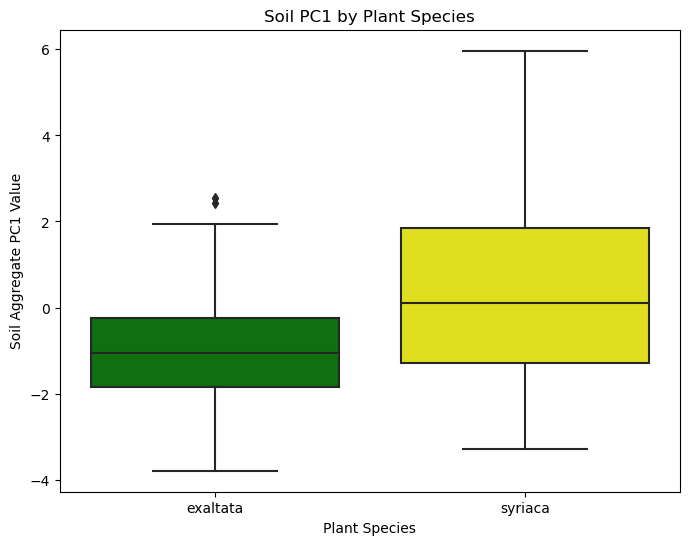

In [55]:
X = df[nutrients]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("PC1 " + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%')
    ax.set_ylabel("PC2 " + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%')
    ax.set_title('PCA with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()
    if graph_type == 'site_id':
        ax.set_title('Sites and Soil Nutrients')
        fig1 = fig
    elif graph_type == 'species':
        ax.set_title('Species and Soil Nutrients')
        fig2 = fig
    else:
        ax.set_title('Broad Geographic Region and Soil Nutrients')
        fig3 = fig
        
components = principal_components
pc1_list = []
for i in components:
    pc1_list.append(i[0])

df['PC1'] = pc1_list

custom_palette = ["green", "yellow"]  # Replace these with your desired colors

plt.figure(figsize=(8, 6))
sns.boxplot(x='species', y='PC1', data=df, palette=custom_palette)
plt.title('Soil PC1 by Plant Species')
plt.xlabel('Plant Species')
plt.ylabel('Soil Aggregate PC1 Value')
plt.savefig('soil_nutrient_plant_boxplot.png', dpi=300, bbox_inches='tight')
#plt.show()

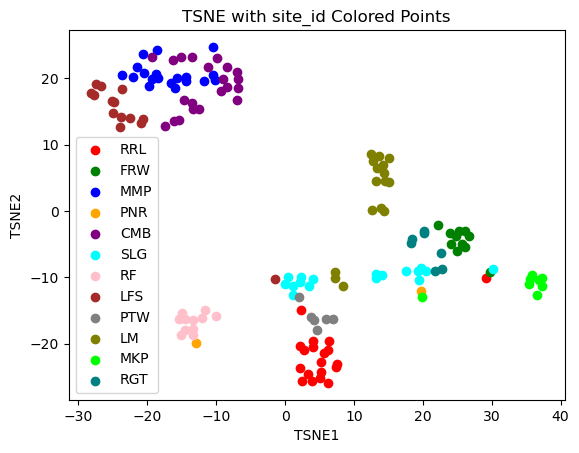

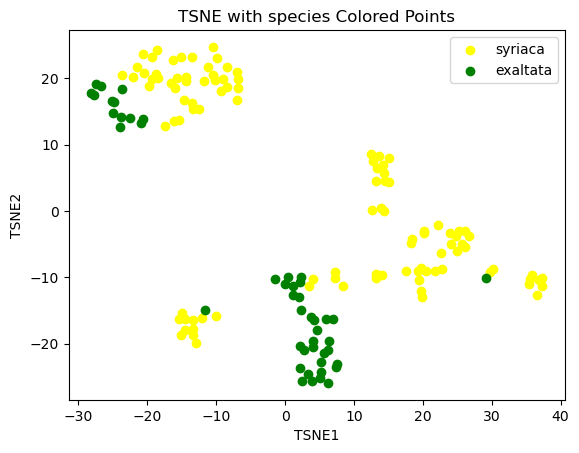

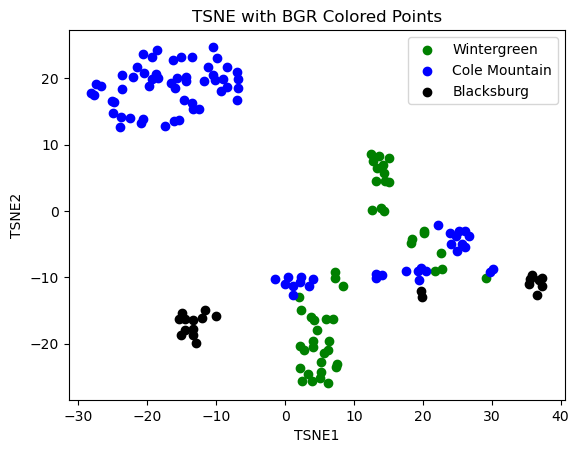

In [56]:
from sklearn.manifold import TSNE

X = df[nutrients]

perplexity_value = 10 # Change this to your desired perplexity

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
tsne_transformed = tsne.fit_transform(df[nutrients])


for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    
#     fig = px.scatter(tsne_transformed, x=0, y=1, color=df[graph_type])
#     fig.update_layout(title = 'Soil Nutrients by Site TSNE Perplexity-Value =' + str(perplexity_value))
#     fig.show()
#     plt.show()

    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            tsne_transformed[mask, 0],
            tsne_transformed[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title('TSNE with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()

    if graph_type == 'site_id':
        ax.set_title('TSNE of Sites Perplexity Value = ' + str(perplexity_value))
        fig4 = fig
    elif graph_type == 'species':
        ax.set_title('TSNE of Species Perplexity Value = ' + str(perplexity_value))
        fig5 = fig
    else:
        ax.set_title('TSNE of Broad Geographic Region Perplexity Value = ' + str(perplexity_value))
        fig6 = fig
    

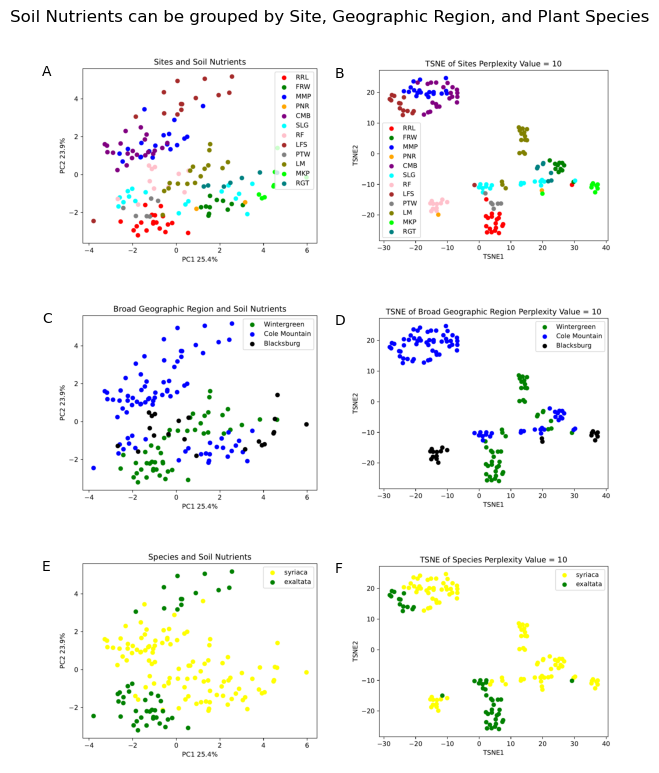

In [61]:
### Save Figures and Create Final Figure
fig1.savefig('soil_nutrient_site_id.pdf', dpi=300, bbox_inches='tight')
fig2.savefig('soil_nutrient_species.pdf', dpi=300, bbox_inches='tight')
fig3.savefig('soil_nutrient_bgr.pdf', dpi=300, bbox_inches='tight')
fig4.savefig('soil_nutrient_site_id_tsne.pdf', dpi=300, bbox_inches='tight')
fig5.savefig('soil_nutrient_species_tsne.pdf', dpi=300, bbox_inches='tight')
fig6.savefig('soil_nutrient_bgr_tsne.pdf', dpi=300, bbox_inches='tight')

img1=convert_from_path('soil_nutrient_site_id.pdf')
img2=convert_from_path('soil_nutrient_bgr.pdf')
img3=convert_from_path('soil_nutrient_species.pdf')
img4=convert_from_path('soil_nutrient_site_id_tsne.pdf')
img5=convert_from_path('soil_nutrient_bgr_tsne.pdf')
img6=convert_from_path('soil_nutrient_species_tsne.pdf')



fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))

ax[0][0].imshow(img1[0])
ax[0][1].imshow(img4[0])
ax[1][0].imshow(img2[0])
ax[1][1].imshow(img5[0])
ax[2][0].imshow(img3[0])
ax[2][1].imshow(img6[0])

# plot 2 subplots
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[2][0].axis('off')
ax[2][1].axis('off')

ax[0][0].annotate("A", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][0].annotate("C", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[0][1].annotate("B", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][1].annotate("D", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][0].annotate("E", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][1].annotate("F", xy=(-0.05, 0.9), xycoords="axes fraction")


fig.suptitle('Soil Nutrients can be grouped by Site, Geographic Region, and Plant Species')
plt.tight_layout()
plt.show()

fig.savefig('combined_soil_nutrients_test.pdf', bbox_inches='tight', dpi = 1000)


In [62]:
# do again but with "genetic species"
v2_list = df['V2']
genetic_list = []
for i in v2_list:
    if i > 0.5:
        genetic_list.append('syriaca')
    else:
        genetic_list.append('exaltata')
df['genetic_species'] = genetic_list

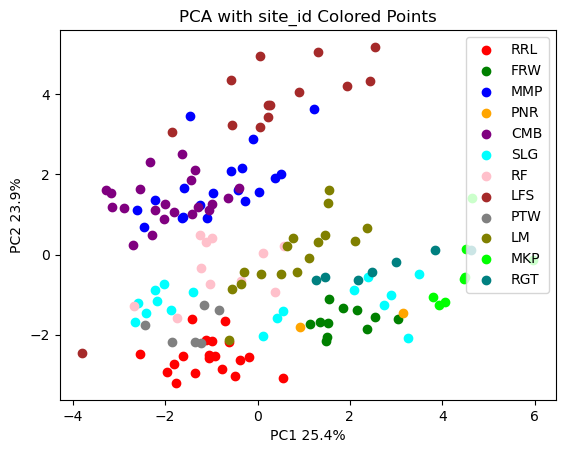

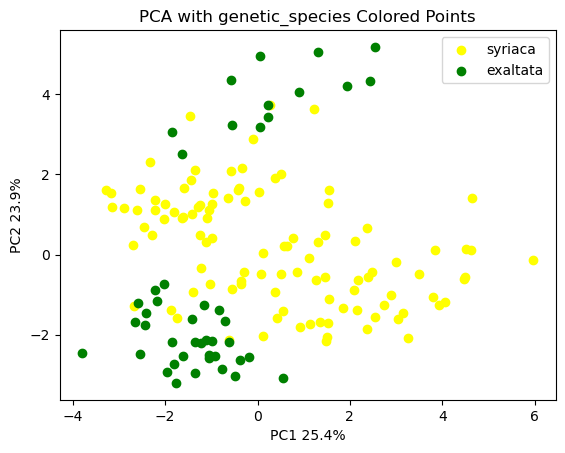

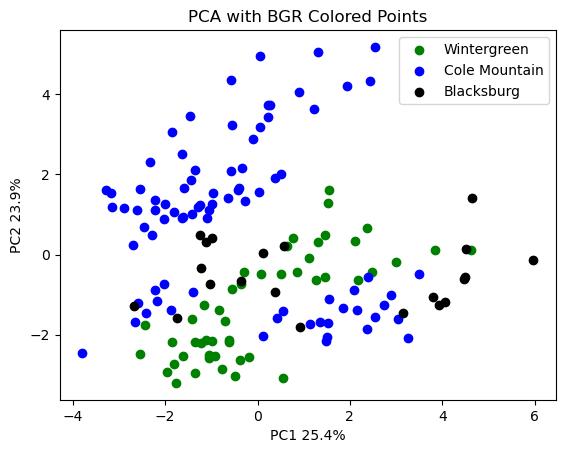

In [63]:
X = df[nutrients]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

for graph_type in ['site_id', 'genetic_species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'genetic_species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("PC1 " + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%')
    ax.set_ylabel("PC2 " + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%')
    ax.set_title('PCA with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()
    if graph_type == 'site_id':
        ax.set_title('Sites and Soil Nutrients')
        fig7 = fig
    elif graph_type == 'genetic_species':
        ax.set_title('Species and Soil Nutrients')
        fig8 = fig
    else:
        ax.set_title('Broad Geographic Region and Soil Nutrients')
        fig9 = fig

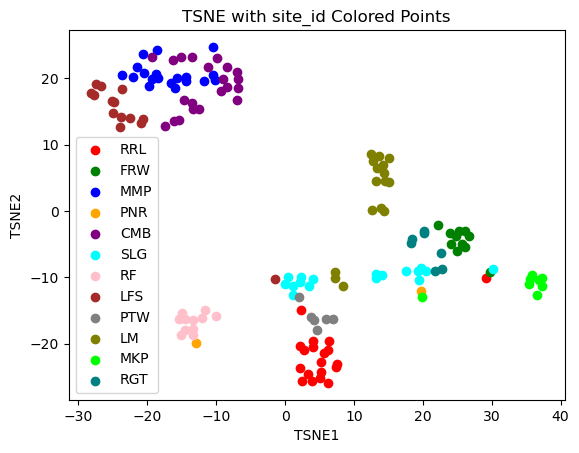

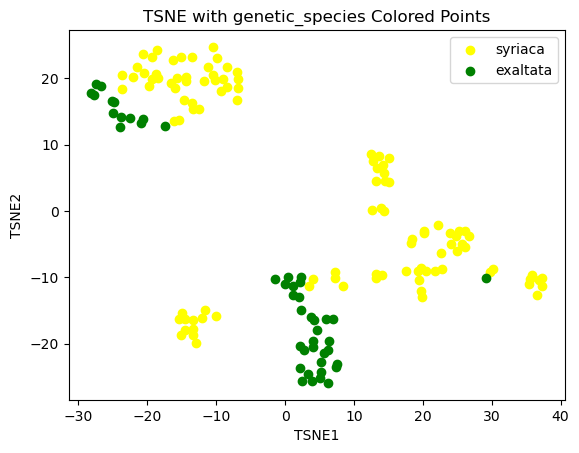

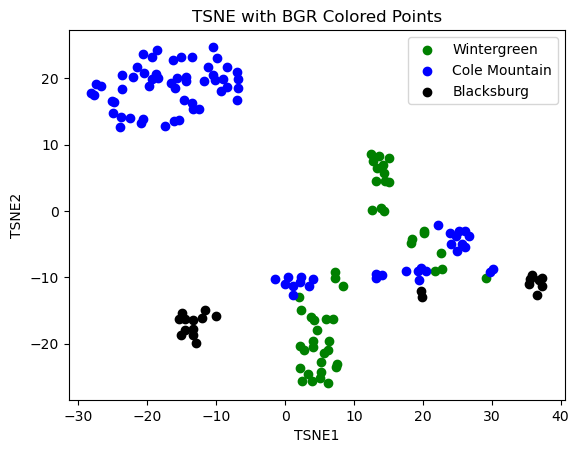

In [64]:
X = df[nutrients]

perplexity_value = 10 # Change this to your desired perplexity

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
tsne_transformed = tsne.fit_transform(df[nutrients])


for graph_type in ['site_id', 'genetic_species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'genetic_species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            tsne_transformed[mask, 0],
            tsne_transformed[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title('TSNE with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()

    if graph_type == 'site_id':
        ax.set_title('TSNE of Sites Perplexity Value = ' + str(perplexity_value))
        fig10 = fig
    elif graph_type == 'genetic_species':
        ax.set_title('TSNE of Species Perplexity Value = ' + str(perplexity_value))
        fig11 = fig
    else:
        ax.set_title('TSNE of Broad Geographic Region Perplexity Value = ' + str(perplexity_value))
        fig12 = fig 

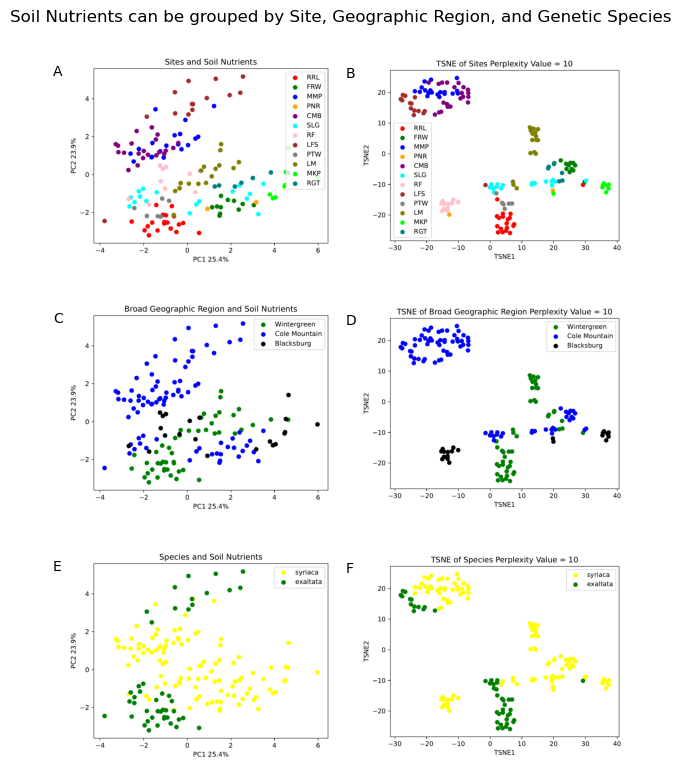

In [67]:
### Save Figures and Create Final Figure
fig7.savefig('soil_nutrient_site_id_2.pdf', dpi=300, bbox_inches='tight')
fig8.savefig('soil_nutrient_species_2.pdf', dpi=300, bbox_inches='tight')
fig9.savefig('soil_nutrient_bgr_2.pdf', dpi=300, bbox_inches='tight')
fig10.savefig('soil_nutrient_site_id_tsne_2.pdf', dpi=300, bbox_inches='tight')
fig11.savefig('soil_nutrient_species_tsne_2.pdf', dpi=300, bbox_inches='tight')
fig12.savefig('soil_nutrient_bgr_tsne_2.pdf', dpi=300, bbox_inches='tight')

img7=convert_from_path('soil_nutrient_site_id_2.pdf')
img8=convert_from_path('soil_nutrient_bgr_2.pdf')
img9=convert_from_path('soil_nutrient_species_2.pdf')
img10=convert_from_path('soil_nutrient_site_id_tsne_2.pdf')
img11=convert_from_path('soil_nutrient_bgr_tsne_2.pdf')
img12=convert_from_path('soil_nutrient_species_tsne_2.pdf')

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))

ax[0][0].imshow(img7[0])
ax[0][1].imshow(img10[0])
ax[1][0].imshow(img8[0])
ax[1][1].imshow(img11[0])
ax[2][0].imshow(img9[0])
ax[2][1].imshow(img12[0])

# plot 2 subplots
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[2][0].axis('off')
ax[2][1].axis('off')

ax[0][0].annotate("A", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][0].annotate("C", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[0][1].annotate("B", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][1].annotate("D", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][0].annotate("E", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][1].annotate("F", xy=(-0.05, 0.9), xycoords="axes fraction")


fig.suptitle('Soil Nutrients can be grouped by Site, Geographic Region, and Genetic Species')
plt.tight_layout()
plt.show()

fig.savefig('combined_soil_nutrients_2.pdf', bbox_inches='tight', dpi = 1000)
# try .pdf for better resolution

In [88]:
X = (df[nutrients]).astype(float)
Y = pd.get_dummies(df['species'])

# Fit the MANOVA model
manova = MANOVA(X, Y)
manova_results = manova.mv_test()

print(manova_results)

                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.5851 16.0000 134.0000  5.9383 0.0000
         Pillai's trace 0.4149 16.0000 134.0000  5.9383 0.0000
 Hotelling-Lawley trace 0.7090 16.0000 134.0000  5.9383 0.0000
    Roy's greatest root 0.7090 16.0000 134.0000  5.9383 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.7630 16.0000 134.0000  2.6015 0.0015
         Pillai's trace 0.2370 16.0000 134.0000  2.6015 0.0015
 Hotelling-